In [5]:
# ─────────────────────────────────────────
# ADR Preprocessing script Machine Learning
# ─────────────────────────────────────────

# Load Packages
import re, string
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
import contractions
from flashtext import KeywordProcessor

# Download required NLTK datasets
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Load drug list and build fast matcher
with open('/content/drive/My Drive/drug_list.txt') as f:
    raw_drugs = sorted({line.strip().lower() for line in f if line.strip()})
drug_kw = KeywordProcessor(case_sensitive=False)
for drug in raw_drugs:
    drug_kw.add_keyword(drug, '<DRUG>')

# Setup NLP tools
stop_eng = set(stopwords.words('english'))
domain_whitelist = {'bp','hr','mg','ml'}
custom_stop = {'dose','take','day'}
stop_eng = (stop_eng - domain_whitelist) | custom_stop

tokenizer   = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stemmer     = PorterStemmer()
lemmatizer  = WordNetLemmatizer()
NEGATION    = {'no','not','never', "n't", 'none'}

EMOJI_MAP = {
    r":\)+": '<SMILE>',
    r":\(+": '<SAD>',
    r";\)+": '<WINK>',
}

# helper to map POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return wordnet.ADJ
    if treebank_tag.startswith('V'): return wordnet.VERB
    if treebank_tag.startswith('N'): return wordnet.NOUN
    if treebank_tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

# Preprocess Pipeline
def preprocess(text: str) -> str:
    # expand contractions
    text = contractions.fix(text)
    # lower and remove URLs, HTML
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    # map emoticons
    for pattern, rep in EMOJI_MAP.items():
        text = re.sub(pattern, f' {rep} ', text)
    # Keep ! and ? sequences
    text = re.sub(r'!{2,}', ' <EXCLAM> ', text)
    text = re.sub(r'\?{2,}', ' <QUES> ', text)
    # remove other punctuation
    text = re.sub(f"[^{re.escape(string.ascii_letters + string.digits + '!?' )}]", ' ', text)
    # numbers
    text = re.sub(r'\d+', '', text)
    # tag multiword drugs
    text = drug_kw.replace_keywords(text)
    # tokenize
    tokens = tokenizer.tokenize(text)
    # tag singleword drugs
    tokens = ['<DRUG>' if t in raw_drugs else t for t in tokens]

    # negation: until punctuation or 3 words
    out_tok = []
    neg_count = 0
    for t in tokens:
        if t in NEGATION:
            neg_count = 3
            out_tok.append(t)
        elif neg_count > 0 and t not in {'!','?'} and t != '<DRUG>':
            out_tok.append(t + '_NEG')
            neg_count -= 1
        else:
            out_tok.append(t)
    tokens = out_tok

    # remove stopwords & short tokens
    filtered = []
    for t in tokens:
        if t == '<DRUG>' or t.startswith('<'):
            filtered.append(t)
        elif t not in stop_eng and (len(t) > 2 or t in domain_whitelist):
            filtered.append(t)
    tokens = filtered

    # POS tag & lemmatize
    tags = pos_tag(tokens)
    lem = []
    for tok, pos in tags:
        if tok.startswith('<'):
            lem.append(tok)
        else:
            wn = get_wordnet_pos(pos)
            lem.append(lemmatizer.lemmatize(tok, wn))

    return ' '.join(lem)


Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
## Load Datasets and apply Preprocessing script

# Reddit
df_reddit = pd.read_csv('/content/drive/My Drive/adr_dataset_REDDIT.csv')
df_reddit.to_csv('df_reddit_cleanedtext.csv', index=False)

# PsyTAR
file_path = '/content/drive/My Drive/PsyTAR_dataset.xlsx'
PsyTAR['clean_text'] = PsyTAR['text'].astype(str).apply(preprocess)

# CADEC_v2 dataset
cadec = pd.read_csv('/content/drive/My Drive/df_cadec.csv')
cadec['clean_text'] = cadec['text'].astype(str).apply(preprocess)

In [7]:
## Combine the 3 datasets and shuffle

train_df = pd.concat([PsyTAR, df_reddit, cadec], ignore_index=True)

# shuffle rows
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [9]:
# Counts for each class in the datasets
for name, df in {
    'CADEC': cadec,
    'Reddit': df_reddit,
    'Train': train_df,
    'PsyTar': PsyTAR
}.items():
    counts = df['ADR'].value_counts().sort_index()
    print(f"{name} ADR counts:\n{counts}\n")


CADEC ADR counts:
ADR
0     226
1    3322
Name: count, dtype: int64

Reddit ADR counts:
ADR
0.0    960
1.0    336
Name: count, dtype: int64

Train ADR counts:
ADR
0.0    5026
1.0    5826
Name: count, dtype: int64

PsyTar ADR counts:
ADR
0.0    3840
1.0    2168
Name: count, dtype: int64



In [ ]:
# ─────────────────────────────────────────
# Baseline Machine Learning Script PsyTAR
# ─────────────────────────────────────────

# Installation of packages
from sklearn.pipeline               import Pipeline
from sklearn.linear_model           import LogisticRegression
from sklearn.naive_bayes            import MultinomialNB
from sklearn.ensemble               import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection       import SelectKBest, chi2
from sklearn.model_selection         import train_test_split
from sklearn.metrics                 import roc_auc_score
from sklearn.base                    import clone
from sklearn.metrics import (
    balanced_accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

# ───────────── Data Prep ─────────────
df = PsyTAR.dropna(subset=['clean_text', 'ADR']).copy()

# Shuffle rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})


# ───────────── Base classifiers ─────────────
base_clfs = {
    'Naïve Bayes':  MultinomialNB(),
    'LogisticReg':  LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost':      xgb.XGBClassifier(
                        objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42
                    )
}

# ───────────── Baseline pipeline ─────────────
def make_baseline(clf):
    return Pipeline([
        ('tfidf',  TfidfVectorizer(token_pattern=r'\S+')),
        ('select', SelectKBest(chi2, k=2000)),
        ('clf',    clf)
    ])

# ───────────── 80 / 20 Train‑Test Split and Evaluation Metrics ─────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("80/20 Train → Test Metrics (baseline only)\n" + "-"*55)
for clf_name, base_clf in base_clfs.items():
    pipe = make_baseline(clone(base_clf))
    pipe.fit(X_train, y_train)

    # Get predictions and scores
    if hasattr(pipe, "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    y_pred = pipe.predict(X_test)

    auc = roc_auc_score(y_test, y_scores)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{clf_name:14s} | AUC: {auc:.2f} | F1: {f1:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | Specificity: {specificity:.2f} | Balanced Accuracy: {bal_acc:.2f}")


80/20 Train → Test Metrics (baseline only)
-------------------------------------------------------
Naïve Bayes    | AUC: 0.91 | F1: 0.74 | Precision: 0.89 | Recall: 0.64 | Specificity: 0.95 | Balanced Accuracy: 0.80
LogisticReg    | AUC: 0.92 | F1: 0.75 | Precision: 0.85 | Recall: 0.67 | Specificity: 0.93 | Balanced Accuracy: 0.80
RandomForest   | AUC: 0.90 | F1: 0.75 | Precision: 0.78 | Recall: 0.72 | Specificity: 0.89 | Balanced Accuracy: 0.80


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:40:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost        | AUC: 0.89 | F1: 0.73 | Precision: 0.81 | Recall: 0.66 | Specificity: 0.91 | Balanced Accuracy: 0.79


In [ ]:
# ─────────────────────────────────────────
# SMOTE Machine Learning Script PsyTAR
# ─────────────────────────────────────────

# Installation of packages
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model        import LogisticRegression
from sklearn.naive_bayes         import MultinomialNB
from sklearn.ensemble            import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection      import SelectKBest, chi2
from sklearn.model_selection        import train_test_split
from sklearn.metrics                import roc_auc_score
from sklearn.base                   import clone
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

# ───────────── Data Prep ─────────────
df = PsyTAR.dropna(subset=['clean_text', 'ADR']).copy()

# Shuffle rows (class ratio preserved by random sampling)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})


# ───────────── Base classifiers ─────────────
base_clfs = {
    'Naïve Bayes':  MultinomialNB(),
    'LogisticReg':  LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost':      xgb.XGBClassifier(
                        objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42
                    )
}

# ───────────── SMOTE pipeline ─────────────

def make_smote(clf):
    return ImbPipeline([
        ('tfidf',  TfidfVectorizer(token_pattern=r'\S+')),
        ('select', SelectKBest(chi2, k=2000)),
        ('smote',  SMOTE(sampling_strategy=0.91, random_state=42)),
        ('clf',    clf)
    ])

# ───────────── 80 / 20 Train‑Test Split Evaluation ─────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("80/20 Train → Test AUC (SMOTE)\n" + "-"*52)
for clf_name, base_clf in base_clfs.items():
    pipe = make_smote(clone(base_clf))
    pipe.fit(X_train, y_train)

    # Get predictions and scores
    if hasattr(pipe, "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    y_pred = pipe.predict(X_test)

    auc = roc_auc_score(y_test, y_scores)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{clf_name:14s} | AUC: {auc:.2f} | F1: {f1:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | Specificity: {specificity:.2f}| Acc: {acc:.2f} | Balanced Accuracy: {bal_acc:.2f}")



80/20 Train → Test AUC (SMOTE)
----------------------------------------------------
Naïve Bayes    | AUC: 0.91 | F1: 0.79 | Precision: 0.80 | Recall: 0.79 | Specificity: 0.89| Acc: 0.85 | Balanced Accuracy: 0.84
LogisticReg    | AUC: 0.91 | F1: 0.80 | Precision: 0.78 | Recall: 0.81 | Specificity: 0.87| Acc: 0.85 | Balanced Accuracy: 0.84
RandomForest   | AUC: 0.90 | F1: 0.77 | Precision: 0.79 | Recall: 0.74 | Specificity: 0.89| Acc: 0.84 | Balanced Accuracy: 0.82


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:56:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost        | AUC: 0.89 | F1: 0.76 | Precision: 0.80 | Recall: 0.73 | Specificity: 0.90| Acc: 0.83 | Balanced Accuracy: 0.81


Running GridSearchCV for each model...

LogisticReg: best CV AUC = 0.88
  Best params: {'clf__C': 1, 'clf__solver': 'lbfgs'}

RandomForest: best CV AUC = 0.88
  Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 300}



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:44:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: best CV AUC = 0.87
  Best params: {'clf__learning_rate': 0.2, 'clf__max_depth': 6, 'clf__n_estimators': 300, 'clf__scale_pos_weight': 1}

NaiveBayes: best CV AUC = 0.88
  Best params: {'clf__alpha': 1.0}


-- LogisticReg on 20 % hold‑out --
AUC:               0.91
Accuracy: 0.84
F1 score:          0.80
Precision:         0.78
Recall (TPR):      0.81
Specificity (TNR): 0.87

-- RandomForest on 20 % hold‑out --
AUC:               0.90
Accuracy: 0.81
F1 score:          0.76
Precision:         0.79
Recall (TPR):      0.74
Specificity (TNR): 0.89

-- XGBoost on 20 % hold‑out --
AUC:               0.89
Accuracy: 0.81
F1 score:          0.76
Precision:         0.78
Recall (TPR):      0.73
Specificity (TNR): 0.89

-- NaiveBayes on 20 % hold‑out --
AUC:               0.91
Accuracy: 0.84
F1 score:          0.79
Precision:         0.80
Recall (TPR):      0.79
Specificity (TNR): 0.89


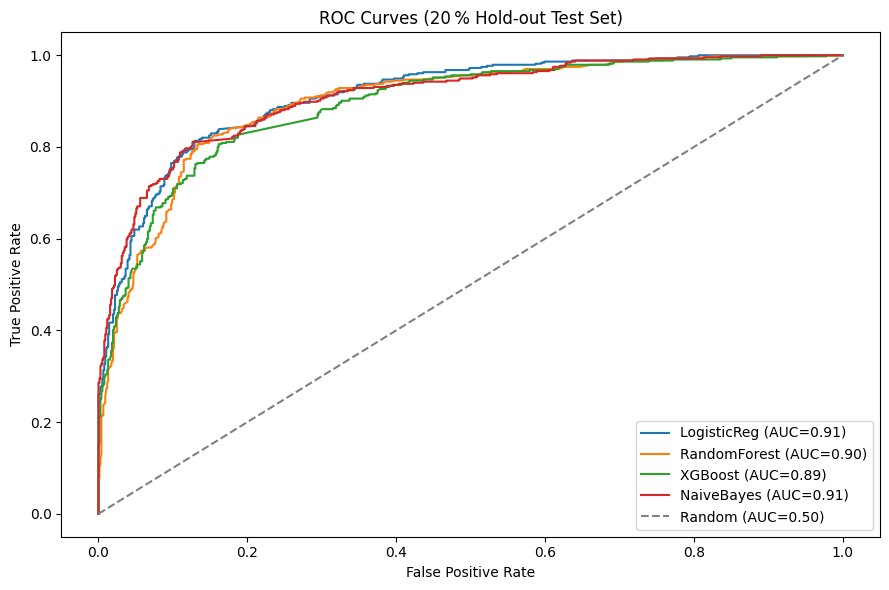

In [ ]:
 # ───────────────────────────────────────────────────
 # GridSearchCV Optimal Pipeline PsyTAR
 # ───────────────────────────────────────────────────

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model             import LogisticRegression
from sklearn.naive_bayes              import MultinomialNB
from sklearn.ensemble                 import RandomForestClassifier
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.feature_selection        import SelectKBest, chi2
from sklearn.model_selection          import (
    StratifiedKFold, GridSearchCV,
    train_test_split
)
from sklearn.metrics                  import (
    roc_curve, auc,
    roc_auc_score, f1_score,
    precision_score, recall_score,
    balanced_accuracy_score, confusion_matrix
)
from sklearn.base                     import clone
from imblearn.pipeline                import Pipeline as ImbPipeline
from imblearn.over_sampling           import SMOTE

# ───────────── Data Prep ─────────────
df = PsyTAR.dropna(subset=['clean_text', 'ADR']).copy()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ───────────── Shared components ─────────────
tfidf    = TfidfVectorizer(token_pattern=r'\S+')
selector = SelectKBest(chi2, k=2000)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helper to build a pipeline with SMOTE
def base_pipe(clf):
    return ImbPipeline([
        ('tfidf',   tfidf),
        ('select',  selector),
        ('smote',  SMOTE(sampling_strategy=0.91, random_state=42)),
        ('clf',     clone(clf))
    ])

# ───────────── Model + Param Grids ─────────────
searches = {
    'LogisticReg': {
        'pipeline': base_pipe(LogisticRegression(max_iter=1000)),
        'params': {
            'clf__C':      [0.01, 0.1, 1, 10, 100],
            'clf__solver': ['lbfgs', 'saga']
        }
    },
    'RandomForest': {
        'pipeline': base_pipe(RandomForestClassifier(random_state=42)),
        'params': {
            'clf__n_estimators':     [100, 300, 500],
            'clf__max_depth':        [None, 10, 20],
            'clf__min_samples_leaf': [1, 2, 5]
        }
    },
    'XGBoost': {
        'pipeline': base_pipe(xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )),
        'params': {
            'clf__n_estimators':     [100, 300],
            'clf__max_depth':        [3, 6, 9],
            'clf__learning_rate':    [0.01, 0.1, 0.2],
            'clf__scale_pos_weight': [1, 2]
        }
    },
    'NaiveBayes': {
        'pipeline': base_pipe(MultinomialNB()),
        'params': {
            'clf__alpha': [0.1, 1.0, 10.0],
        }
    }
}

# ───────────── Hyperparameter Search ─────────────
best_models = {}
print("Running GridSearchCV for each model...\n")
for name, cfg in searches.items():
    gs = GridSearchCV(
        cfg['pipeline'],
        cfg['params'],
        scoring='roc_auc',
        cv=inner_cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    print(f"{name}: best CV AUC = {gs.best_score_:.3f}")
    print(f"  Best params: {gs.best_params_}\n")

# ───────────── Evaluation on 20 % Hold‑out ─────────────
plt.figure(figsize=(9, 6))

for name, model in best_models.items():
    # Predict probabilities and labels
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred  = model.predict(X_test)

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={model_auc:.2f})")

    # Other metrics
    auc_score    = roc_auc_score(y_test, y_proba)
    f1           = f1_score(y_test, y_pred)
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    bal_acc      = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity  = tn / (tn + fp)

    print(f"\n-- {name} on 20 % hold‑out --")
    print(f"AUC:               {auc_score:.2f}")
    print(f"Accuracy: {bal_acc:.2f}")
    print(f"F1 score:          {f1:.2f}")
    print(f"Precision:         {precision:.2f}")
    print(f"Recall (TPR):      {recall:.2f}")
    print(f"Specificity (TNR): {specificity:.2f}")

# Chance line
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random (AUC=0.50)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (20 % Hold‑out Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



In [ ]:
# ─────────────────────────────────────────
# Baseline Machine Learning Script cadec
# ─────────────────────────────────────────

# Installation of packages
from sklearn.pipeline                import Pipeline
from sklearn.linear_model            import LogisticRegression
from sklearn.naive_bayes             import MultinomialNB
from sklearn.ensemble                import RandomForestClassifier
import xgboost                       as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection       import SelectKBest, chi2
from sklearn.model_selection         import train_test_split
from sklearn.metrics                 import roc_auc_score
from sklearn.base                    import clone
from sklearn.metrics                 import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)
# ───────────── Data Prep ─────────────
df = cadec.dropna(subset=['clean_text', 'ADR']).copy()

# Shuffle rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})


# ───────────── Base classifiers ─────────────
base_clfs = {
    'Naïve Bayes':  MultinomialNB(),
    'LogisticReg':  LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost':      xgb.XGBClassifier(
                        objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42
                    )
}

# ───────────── Baseline pipeline ─────────────
def make_baseline(clf):
    return Pipeline([
        ('tfidf',  TfidfVectorizer(token_pattern=r'\S+')),
        ('select', SelectKBest(chi2, k=2000)),
        ('clf',    clf)
    ])

# ───────────── 80 / 20 Train‑Test Split Evaluation ─────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("80/20 Train → Test Metrics (baseline only)\n" + "-"*55)
for clf_name, base_clf in base_clfs.items():
    pipe = make_baseline(clone(base_clf))
    pipe.fit(X_train, y_train)

    # Get predictions and scores
    if hasattr(pipe, "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    y_pred = pipe.predict(X_test)

    auc = roc_auc_score(y_test, y_scores)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{clf_name:14s} | AUC: {auc:.2f} | F1: {f1:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | Specificity: {specificity:.2f}| Acc: {acc:.2f} | Balanced Accuracy: {bal_acc:.2f}")


80/20 Train → Test Metrics (baseline only)
-------------------------------------------------------
Naïve Bayes    | AUC: 0.92 | F1: 0.97 | Precision: 0.94 | Recall: 1.00 | Specificity: 0.00| Acc: 0.94 | Balanced Accuracy: 0.50
LogisticReg    | AUC: 0.93 | F1: 0.97 | Precision: 0.94 | Recall: 1.00 | Specificity: 0.00| Acc: 0.94 | Balanced Accuracy: 0.50
RandomForest   | AUC: 0.85 | F1: 0.97 | Precision: 0.95 | Recall: 0.99 | Specificity: 0.20| Acc: 0.94 | Balanced Accuracy: 0.60


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:57:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost        | AUC: 0.92 | F1: 0.97 | Precision: 0.95 | Recall: 0.99 | Specificity: 0.27| Acc: 0.95 | Balanced Accuracy: 0.63


In [ ]:
# ─────────────────────────────────────────
# SMOTE Machine Learning Script cadec
# ─────────────────────────────────────────

# Installation of packages
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model        import LogisticRegression
from sklearn.naive_bayes         import MultinomialNB
from sklearn.ensemble            import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection      import SelectKBest, chi2
from sklearn.model_selection        import train_test_split
from sklearn.metrics                import roc_auc_score
from sklearn.base                   import clone
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

# ───────────── Data Prep ─────────────
df = cadec.dropna(subset=['clean_text', 'ADR']).copy()

# Shuffle rows (class ratio preserved by random sampling)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})



# ───────────── Base classifiers ─────────────
base_clfs = {
    'Naïve Bayes':  MultinomialNB(),
    'LogisticReg':  LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost':      xgb.XGBClassifier(
                        objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42
                    )
}

# ───────────── SMOTE pipeline ─────────────
#
def make_smote(clf):
    return ImbPipeline([
        ('tfidf',  TfidfVectorizer(token_pattern=r'\S+')),
        ('select', SelectKBest(chi2, k=2000)),
        ('smote',  SMOTE(sampling_strategy=0.96, random_state=42)),
        ('clf',    clf)
    ])

# ───────────── 80 / 20 Train‑Test Split Evaluation ─────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

print("80/20 Train → Test AUC (SMOTE)\n" + "-"*52)
for clf_name, base_clf in base_clfs.items():
    pipe = make_smote(clone(base_clf))
    pipe.fit(X_train, y_train)

    # Get predictions and scores
    if hasattr(pipe, "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    y_pred = pipe.predict(X_test)

    auc = roc_auc_score(y_test, y_scores)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{clf_name:14s} | AUC: {auc:.2f} | F1: {f1:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | Specificity: {specificity:.2f}| Acc: {acc:.2f} | Balanced Accuracy: {bal_acc:.2f}")


80/20 Train → Test AUC (SMOTE)
----------------------------------------------------
Naïve Bayes    | AUC: 0.94 | F1: 0.97 | Precision: 0.96 | Recall: 0.98 | Specificity: 0.47| Acc: 0.95 | Balanced Accuracy: 0.72
LogisticReg    | AUC: 0.93 | F1: 0.97 | Precision: 0.96 | Recall: 0.97 | Specificity: 0.44| Acc: 0.94 | Balanced Accuracy: 0.71
RandomForest   | AUC: 0.92 | F1: 0.97 | Precision: 0.95 | Recall: 0.99 | Specificity: 0.20| Acc: 0.94 | Balanced Accuracy: 0.60


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:58:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost        | AUC: 0.91 | F1: 0.97 | Precision: 0.95 | Recall: 0.98 | Specificity: 0.31| Acc: 0.94 | Balanced Accuracy: 0.64


Running GridSearchCV for each model...

LogisticReg: best CV AUC = 0.918
  Best params: {'clf__C': 1, 'clf__solver': 'lbfgs'}

RandomForest: best CV AUC = 0.907
  Best params: {'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 500}



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:53:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: best CV AUC = 0.898
  Best params: {'clf__learning_rate': 0.2, 'clf__max_depth': 6, 'clf__n_estimators': 100, 'clf__scale_pos_weight': 2}

NaiveBayes: best CV AUC = 0.935
  Best params: {'clf__alpha': 1.0}


-- LogisticReg on 20 % hold‑out --
AUC:               0.93
Accuracy: 0.71
F1 score:          0.97
Precision:         0.96
Recall (TPR):      0.97
Specificity (TNR): 0.44

-- RandomForest on 20 % hold‑out --
AUC:               0.93
Accuracy: 0.64
F1 score:          0.97
Precision:         0.95
Recall (TPR):      0.99
Specificity (TNR): 0.29

-- XGBoost on 20 % hold‑out --
AUC:               0.91
Accuracy: 0.64
F1 score:          0.97
Precision:         0.95
Recall (TPR):      0.98
Specificity (TNR): 0.29

-- NaiveBayes on 20 % hold‑out --
AUC:               0.94
Accuracy: 0.72
F1 score:          0.97
Precision:         0.96
Recall (TPR):      0.98
Specificity (TNR): 0.47


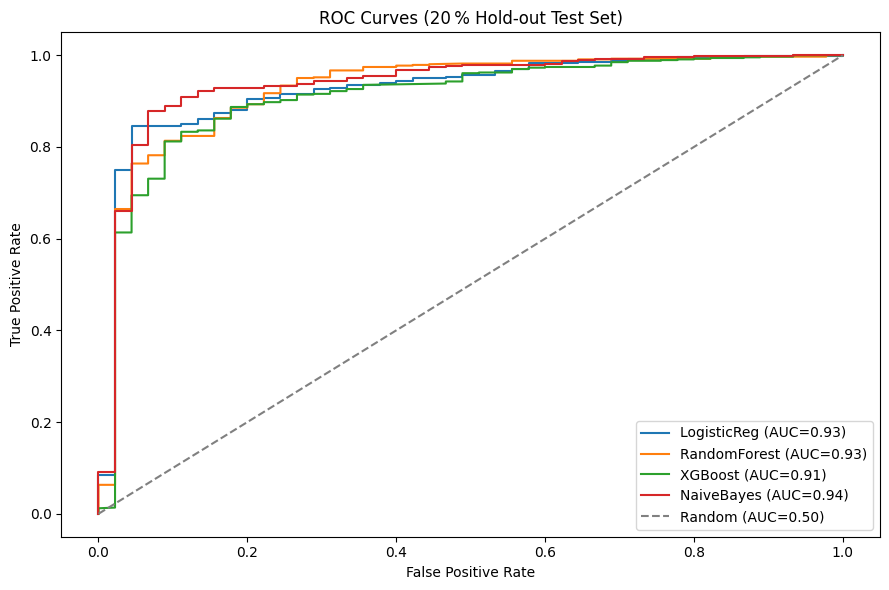

In [ ]:
 # ───────────────────────────────────────────────────
 # GridSearchCV Optimal Pipeline CADEC
 # ───────────────────────────────────────────────────

import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model             import LogisticRegression
from sklearn.naive_bayes              import MultinomialNB
from sklearn.ensemble                 import RandomForestClassifier
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.feature_selection        import SelectKBest, chi2
from sklearn.model_selection          import (
    StratifiedKFold, GridSearchCV,
    train_test_split
)
from sklearn.metrics                  import (
    roc_curve, auc,
    roc_auc_score, f1_score,
    precision_score, recall_score,
    balanced_accuracy_score, confusion_matrix
)
from sklearn.base                     import clone
from imblearn.pipeline                import Pipeline as ImbPipeline
from imblearn.over_sampling           import SMOTE


# ───────────── Data Prep ─────────────
df = cadec.dropna(subset=['clean_text', 'ADR']).copy()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ───────────── Shared components ─────────────
tfidf    = TfidfVectorizer(token_pattern=r'\S+')
selector = SelectKBest(chi2, k=2000)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helper to build a pipeline with SMOTE
def base_pipe(clf):
    return ImbPipeline([
        ('tfidf',   tfidf),
        ('select',  selector),
        ('smote',  SMOTE(sampling_strategy=0.96, random_state=42)),
        ('clf',     clone(clf))
    ])

# ───────────── Model + Param Grids ─────────────
searches = {
    'LogisticReg': {
        'pipeline': base_pipe(LogisticRegression(max_iter=1000)),
        'params': {
            'clf__C':      [0.01, 0.1, 1, 10, 100],
            'clf__solver': ['lbfgs', 'saga']
        }
    },
    'RandomForest': {
        'pipeline': base_pipe(RandomForestClassifier(random_state=42)),
        'params': {
            'clf__n_estimators':     [100, 300, 500],
            'clf__max_depth':        [None, 10, 20],
            'clf__min_samples_leaf': [1, 2, 5]
        }
    },
    'XGBoost': {
        'pipeline': base_pipe(xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )),
        'params': {
            'clf__n_estimators':     [100, 300],
            'clf__max_depth':        [3, 6, 9],
            'clf__learning_rate':    [0.01, 0.1, 0.2],
            'clf__scale_pos_weight': [1, 2]
        }
    },
    'NaiveBayes': {
        'pipeline': base_pipe(MultinomialNB()),
        'params': {
            'clf__alpha': [0.1, 1.0, 10.0],
        }
    }
}

# ───────────── Hyperparameter Search ─────────────
best_models = {}
print("Running GridSearchCV for each model...\n")
for name, cfg in searches.items():
    gs = GridSearchCV(
        cfg['pipeline'],
        cfg['params'],
        scoring='roc_auc',
        cv=inner_cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    print(f"{name}: best CV AUC = {gs.best_score_:.3f}")
    print(f"  Best params: {gs.best_params_}\n")

# ───────────── Evaluation on 20 % Hold‑out ─────────────
plt.figure(figsize=(9, 6))

for name, model in best_models.items():
    # Predict probabilities and labels
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred  = model.predict(X_test)

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={model_auc:.2f})")

    # Other metrics
    auc_score    = roc_auc_score(y_test, y_proba)
    f1           = f1_score(y_test, y_pred)
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    bal_acc      = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity  = tn / (tn + fp)

    print(f"\n-- {name} on 20 % hold‑out --")
    print(f"AUC:               {auc_score:.2f}")
    print(f"Accuracy: {bal_acc:.2f}")
    print(f"F1 score:          {f1:.2f}")
    print(f"Precision:         {precision:.2f}")
    print(f"Recall (TPR):      {recall:.2f}")
    print(f"Specificity (TNR): {specificity:.2f}")

# Chance line
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random (AUC=0.50)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (20 % Hold‑out Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
# ─────────────────────────────────────────
# Baseline Machine Learning Script REDDIT
# ─────────────────────────────────────────

# Installation of packages
from sklearn.pipeline            import Pipeline
from sklearn.linear_model        import LogisticRegression
from sklearn.naive_bayes         import MultinomialNB
from sklearn.ensemble            import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection      import SelectKBest, chi2
from sklearn.model_selection        import train_test_split
from sklearn.metrics                import roc_auc_score
from sklearn.base                   import clone
from sklearn.metrics                import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)
# ───────────── Data Prep ─────────────
df = df_reddit.dropna(subset=['clean_text', 'ADR']).copy()

# Shuffle rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})

# ───────────── Base classifiers ─────────────
base_clfs = {
    'Naïve Bayes':  MultinomialNB(),
    'LogisticReg':  LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost':      xgb.XGBClassifier(
                        objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42
                    )
}

# ───────────── Baseline pipeline ─────────────
def make_baseline(clf):
    return Pipeline([
        ('tfidf',  TfidfVectorizer(token_pattern=r'\S+')),
        ('select', SelectKBest(chi2, k=2000)),
        ('clf',    clf)
    ])

# ───────────── 80 / 20 Train‑Test Split Evaluation ─────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("80/20 Train → Test Metrics (baseline only)\n" + "-"*55)
for clf_name, base_clf in base_clfs.items():
    pipe = make_baseline(clone(base_clf))
    pipe.fit(X_train, y_train)

    # Get predictions and scores
    if hasattr(pipe, "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    y_pred = pipe.predict(X_test)

    auc = roc_auc_score(y_test, y_scores)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{clf_name:14s} | AUC: {auc:.2f} | F1: {f1:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | Specificity: {specificity:.2f}| Acc: {acc:.2f} | Balanced Accuracy: {bal_acc:.2f}")


80/20 Train → Test Metrics (baseline only)
-------------------------------------------------------
Naïve Bayes    | AUC: 0.78 | F1: 0.00 | Precision: 0.00 | Recall: 0.00 | Specificity: 1.00| Acc: 0.74 | Balanced Accuracy: 0.50
LogisticReg    | AUC: 0.86 | F1: 0.40 | Precision: 0.75 | Recall: 0.27 | Specificity: 0.97| Acc: 0.79 | Balanced Accuracy: 0.62
RandomForest   | AUC: 0.85 | F1: 0.42 | Precision: 0.95 | Recall: 0.27 | Specificity: 0.99| Acc: 0.81 | Balanced Accuracy: 0.63


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:59:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost        | AUC: 0.83 | F1: 0.60 | Precision: 0.63 | Recall: 0.57 | Specificity: 0.89| Acc: 0.80 | Balanced Accuracy: 0.73


In [ ]:
# ─────────────────────────────────────────
# SMOTE Machine Learning Script REDDIT
# ─────────────────────────────────────────

# Installation of packages
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model        import LogisticRegression
from sklearn.naive_bayes         import MultinomialNB
from sklearn.ensemble            import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection      import SelectKBest, chi2
from sklearn.model_selection        import train_test_split
from sklearn.metrics                import roc_auc_score
from sklearn.base                   import clone
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

# ───────────── Data Prep ─────────────
df = df_reddit.dropna(subset=['clean_text', 'ADR']).copy()

# Shuffle rows (class ratio preserved by random sampling)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})



# ───────────── Base classifiers ─────────────
base_clfs = {
    'Naïve Bayes':  MultinomialNB(),
    'LogisticReg':  LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost':      xgb.XGBClassifier(
                        objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42
                    )
}

# ───────────── SMOTE pipeline ─────────────
#
def make_smote(clf):
    return ImbPipeline([
        ('tfidf',  TfidfVectorizer(token_pattern=r'\S+')),
        ('select', SelectKBest(chi2, k=2000)),
        ('smote',  SMOTE(sampling_strategy=0.96, random_state=42)),
        ('clf',    clf)
    ])

# ───────────── 80 / 20 Train‑Test Split Evaluation ─────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("80/20 Train → Test AUC (SMOTE)\n" + "-"*52)
for clf_name, base_clf in base_clfs.items():
    pipe = make_smote(clone(base_clf))
    pipe.fit(X_train, y_train)

    # Get predictions and scores
    if hasattr(pipe, "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    y_pred = pipe.predict(X_test)

    auc = roc_auc_score(y_test, y_scores)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{clf_name:14s} | AUC: {auc:.2f} | F1: {f1:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | Specificity: {specificity:.2f}| Acc: {acc:.2f} | Balanced Accuracy: {bal_acc:.2f}")


80/20 Train → Test AUC (SMOTE)
----------------------------------------------------
Naïve Bayes    | AUC: 0.84 | F1: 0.56 | Precision: 0.44 | Recall: 0.79 | Specificity: 0.65| Acc: 0.68 | Balanced Accuracy: 0.72
LogisticReg    | AUC: 0.84 | F1: 0.64 | Precision: 0.58 | Recall: 0.70 | Specificity: 0.82| Acc: 0.79 | Balanced Accuracy: 0.76
RandomForest   | AUC: 0.81 | F1: 0.49 | Precision: 0.85 | Recall: 0.34 | Specificity: 0.98| Acc: 0.82 | Balanced Accuracy: 0.66


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:59:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost        | AUC: 0.84 | F1: 0.55 | Precision: 0.56 | Recall: 0.54 | Specificity: 0.85| Acc: 0.77 | Balanced Accuracy: 0.70


Running GridSearchCV for each model...

LogisticReg: best CV AUC = 0.819
  Best params: {'clf__C': 1, 'clf__solver': 'lbfgs'}

RandomForest: best CV AUC = 0.819
  Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 500}



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:08:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: best CV AUC = 0.817
  Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__scale_pos_weight': 2}

NaiveBayes: best CV AUC = 0.816
  Best params: {'clf__alpha': 10.0}


-- LogisticReg on 20 % hold‑out --
AUC:               0.84
Accuracy: 0.76
F1 score:          0.64
Precision:         0.58
Recall (TPR):      0.70
Specificity (TNR): 0.82

-- RandomForest on 20 % hold‑out --
AUC:               0.83
Accuracy: 0.69
F1 score:          0.54
Precision:         0.76
Recall (TPR):      0.42
Specificity (TNR): 0.95

-- XGBoost on 20 % hold‑out --
AUC:               0.87
Accuracy: 0.78
F1 score:          0.66
Precision:         0.60
Recall (TPR):      0.73
Specificity (TNR): 0.83

-- NaiveBayes on 20 % hold‑out --
AUC:               0.85
Accuracy: 0.69
F1 score:          0.53
Precision:         0.37
Recall (TPR):      0.94
Specificity (TNR): 0.45


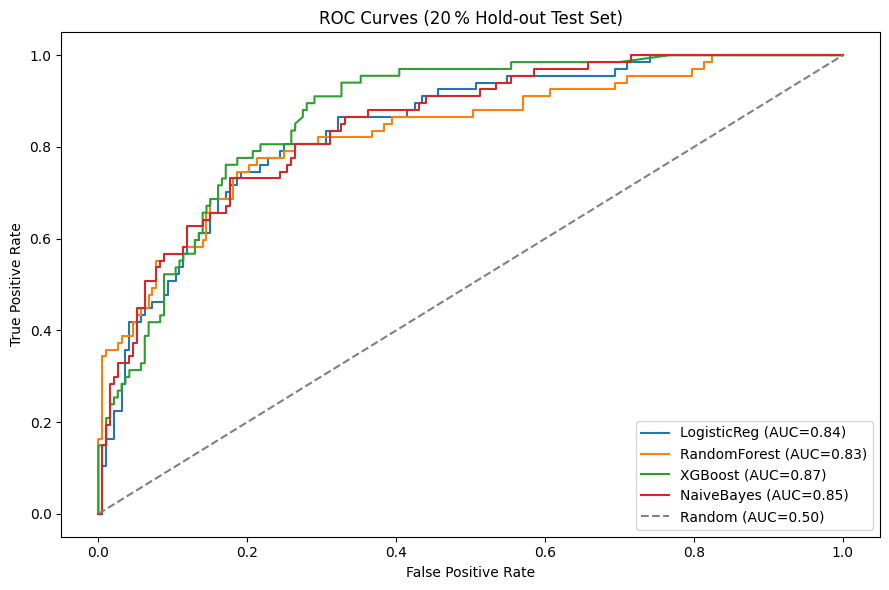

In [ ]:
# ───────────────────────────────────────────────────
# GridSearchCV Optimal Pipeline with Test Set Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model             import LogisticRegression
from sklearn.naive_bayes              import MultinomialNB
from sklearn.ensemble                 import RandomForestClassifier
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.feature_selection        import SelectKBest, chi2
from sklearn.model_selection          import (
    StratifiedKFold, GridSearchCV,
    train_test_split
)
from sklearn.metrics                  import (
    roc_curve, auc,
    roc_auc_score, f1_score,
    precision_score, recall_score,
    balanced_accuracy_score, confusion_matrix
)
from sklearn.base                     import clone
from imblearn.pipeline                import Pipeline as ImbPipeline
from imblearn.over_sampling           import SMOTE

# ───────────── Data Prep ─────────────
df = df_reddit.dropna(subset=['clean_text', 'ADR']).copy()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})

# 80 / 20 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ───────────── Shared components ─────────────
tfidf    = TfidfVectorizer(token_pattern=r'\S+')
selector = SelectKBest(chi2, k=2000)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helper to build a SMOTE pipeline
def smote_pipe(clf):
    return ImbPipeline([
        ('tfidf',  tfidf),
        ('select', selector),
        ('smote',  SMOTE(sampling_strategy=0.96, random_state=42)),
        ('clf',    clone(clf))
    ])

# ───────────── Model + Param Grids ─────────────
searches = {
    # ---------- SMOTE models ----------
    'LogisticReg': {
        'pipeline': smote_pipe(LogisticRegression(
            max_iter=1000
        )),
        'params': {
            'clf__C':      [0.01, 0.1, 1, 10, 100],
            'clf__solver': ['lbfgs', 'saga']
        }
    },
    'RandomForest': {
        'pipeline': smote_pipe(RandomForestClassifier(random_state=42)),
        'params': {
            'clf__n_estimators':     [100, 300, 500],
            'clf__max_depth':        [None, 10, 20],
            'clf__min_samples_leaf': [1, 2, 5]
        }
    },
    'XGBoost': {
        'pipeline': make_baseline(xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )),
        'params': {
            'clf__n_estimators':     [100, 300],
            'clf__max_depth':        [3, 6, 9],
            'clf__learning_rate':    [0.01, 0.1, 0.2],
            'clf__scale_pos_weight': [1, 2]
        }
    },
   'NaiveBayes': {
        'pipeline': smote_pipe(MultinomialNB()),
        'params': {
            'clf__alpha': [0.1, 1.0, 10.0],  # Smoothing parameter for Naive Bayes
        }
    }
}

# ───────────── Hyperparameter Search ─────────────
best_models = {}
print("Running GridSearchCV for each model...\n")
for name, cfg in searches.items():
    gs = GridSearchCV(
        cfg['pipeline'],
        cfg['params'],
        scoring='roc_auc',
        cv=inner_cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    print(f"{name}: best CV AUC = {gs.best_score_:.3f}")
    print(f"  Best params: {gs.best_params_}\n")

# ───────────── Evaluation on 20 % Hold‑out ─────────────

plt.figure(figsize=(9, 6))

for name, model in best_models.items():
    # Predict probabilities and labels
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred  = model.predict(X_test)

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={model_auc:.2f})")

    # Other metrics
    auc_score    = roc_auc_score(y_test, y_proba)
    f1           = f1_score(y_test, y_pred)
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    bal_acc      = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity  = tn / (tn + fp)

    print(f"\n-- {name} on 20 % hold‑out --")
    print(f"AUC:               {auc_score:.2f}")
    print(f"Accuracy: {bal_acc:.2f}")
    print(f"F1 score:          {f1:.2f}")
    print(f"Precision:         {precision:.2f}")
    print(f"Recall (TPR):      {recall:.2f}")
    print(f"Specificity (TNR): {specificity:.2f}")

# Chance line
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random (AUC=0.50)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (20 % Hold‑out Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
# ─────────────────────────────────────────
# Combined Baseline Machine Learning Script
# ─────────────────────────────────────────

# Installation of packages
from sklearn.pipeline            import Pipeline
from sklearn.linear_model        import LogisticRegression
from sklearn.naive_bayes         import MultinomialNB
from sklearn.ensemble            import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection      import SelectKBest, chi2
from sklearn.model_selection        import train_test_split
from sklearn.metrics                import roc_auc_score
from sklearn.base                   import clone

# ───────────── Data Prep ─────────────
df = train_df.dropna(subset=['clean_text', 'ADR']).copy()

# Shuffle rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})


# ───────────── Base classifiers ─────────────
base_clfs = {
    'Naïve Bayes':  MultinomialNB(),
    'LogisticReg':  LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost':      xgb.XGBClassifier(
                        objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42
                    )
}

# ───────────── Baseline pipeline ─────────────
def make_baseline(clf):
    return Pipeline([
        ('tfidf',  TfidfVectorizer(token_pattern=r'\S+')),
        ('select', SelectKBest(chi2, k=2000)),
        ('clf',    clf)
    ])

# ───────────── 80 / 20 Train‑Test Split Evaluation ─────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

print("80/20 Train → Test Metrics (baseline only)\n" + "-"*55)
for clf_name, base_clf in base_clfs.items():
    pipe = make_baseline(clone(base_clf))
    pipe.fit(X_train, y_train)

    # Get predictions and scores
    if hasattr(pipe, "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    y_pred = pipe.predict(X_test)

    auc = roc_auc_score(y_test, y_scores)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{clf_name:14s} | AUC: {auc:.2f} | F1: {f1:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | Specificity: {specificity:.2f}| Acc: {acc:.2f} | Balanced Accuracy: {bal_acc:.2f}")


80/20 Train → Test Metrics (baseline only)
-------------------------------------------------------
Naïve Bayes    | AUC: 0.88 | F1: 0.79 | Precision: 0.70 | Recall: 0.92 | Specificity: 0.54| Acc: 0.74 | Balanced Accuracy: 0.73
LogisticReg    | AUC: 0.91 | F1: 0.84 | Precision: 0.86 | Recall: 0.82 | Specificity: 0.84| Acc: 0.83 | Balanced Accuracy: 0.83
RandomForest   | AUC: 0.90 | F1: 0.83 | Precision: 0.84 | Recall: 0.82 | Specificity: 0.82| Acc: 0.82 | Balanced Accuracy: 0.82


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:00:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost        | AUC: 0.90 | F1: 0.82 | Precision: 0.86 | Recall: 0.79 | Specificity: 0.85| Acc: 0.82 | Balanced Accuracy: 0.82


In [ ]:
# ─────────────────────────────────────────
# SMOTE Machine Learning Script
# ─────────────────────────────────────────

# Installation of packages
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model        import LogisticRegression
from sklearn.naive_bayes         import MultinomialNB
from sklearn.ensemble            import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection      import SelectKBest, chi2
from sklearn.model_selection        import train_test_split
from sklearn.metrics                import roc_auc_score
from sklearn.base                   import clone
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

# ───────────── Data Prep ─────────────
df = train_df.dropna(subset=['clean_text', 'ADR']).copy()

# Shuffle rows (class ratio preserved by random sampling)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})

# ───────────── Base classifiers ─────────────
base_clfs = {
    'Naïve Bayes':  MultinomialNB(),
    'LogisticReg':  LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost':      xgb.XGBClassifier(
                        objective='binary:logistic',
                        eval_metric='logloss',
                        use_label_encoder=False,
                        random_state=42
                    )
}

# ───────────── SMOTE pipeline ─────────────
#
def make_smote(clf):
    return ImbPipeline([
        ('tfidf',  TfidfVectorizer(token_pattern=r'\S+')),
        ('select', SelectKBest(chi2, k=2000)),
        ('smote',  SMOTE(sampling_strategy=0.96, random_state=42)),
        ('clf',    clf)
    ])

# ───────────── 80 / 20 Train‑Test Split Evaluation ─────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("80/20 Train → Test AUC (SMOTE)\n" + "-"*52)
for clf_name, base_clf in base_clfs.items():
    pipe = make_smote(clone(base_clf))
    pipe.fit(X_train, y_train)

    # Get predictions and scores
    if hasattr(pipe, "predict_proba"):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        y_scores = pipe.decision_function(X_test)

    y_pred = pipe.predict(X_test)

    auc = roc_auc_score(y_test, y_scores)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)

    # Specificity = TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"{clf_name:14s} | AUC: {auc:.2f} | F1: {f1:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | Specificity: {specificity:.2f}| Acc: {acc:.2f} | Balanced Accuracy: {bal_acc:.2f}")


80/20 Train → Test AUC (SMOTE)
----------------------------------------------------
Naïve Bayes    | AUC: 0.88 | F1: 0.81 | Precision: 0.75 | Recall: 0.88 | Specificity: 0.65| Acc: 0.78 | Balanced Accuracy: 0.77
LogisticReg    | AUC: 0.91 | F1: 0.83 | Precision: 0.87 | Recall: 0.80 | Specificity: 0.86| Acc: 0.83 | Balanced Accuracy: 0.83
RandomForest   | AUC: 0.90 | F1: 0.84 | Precision: 0.85 | Recall: 0.82 | Specificity: 0.83| Acc: 0.83 | Balanced Accuracy: 0.83


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:00:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost        | AUC: 0.91 | F1: 0.82 | Precision: 0.87 | Recall: 0.77 | Specificity: 0.86| Acc: 0.81 | Balanced Accuracy: 0.82


In [ ]:
# ───────────────────────────────────────────────────
# GridSearchCV Optimal Pipeline with Test Set Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model             import LogisticRegression
from sklearn.naive_bayes              import MultinomialNB
from sklearn.ensemble                 import RandomForestClassifier
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.feature_selection        import SelectKBest, chi2
from sklearn.model_selection          import (
    StratifiedKFold, GridSearchCV,
    train_test_split
)
from sklearn.metrics                  import (
    roc_curve, auc,
    roc_auc_score, f1_score,
    precision_score, recall_score,
    balanced_accuracy_score, confusion_matrix
)
from sklearn.base                     import clone
from imblearn.pipeline                import Pipeline as ImbPipeline
from imblearn.over_sampling           import SMOTE

# ───────────── Data Prep ─────────────
df = train_df.dropna(subset=['clean_text', 'ADR']).copy()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df['clean_text']
y = df['ADR'].map({0.0: 0, 1.0: 1})

# 80 / 20 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# ───────────── Shared components ─────────────
tfidf    = TfidfVectorizer(token_pattern=r'\S+')
selector = SelectKBest(chi2, k=2000)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helper to build a SMOTE pipeline
def smote_pipe(clf):
    return ImbPipeline([
        ('tfidf',  tfidf),
        ('select', selector),
        ('smote',  SMOTE(sampling_strategy=0.96, random_state=42)),
        ('clf',    clone(clf))
    ])

# ───────────── Model + Param Grids ─────────────
searches = {
    # ---------- SMOTE models ----------
    'LogisticReg': {
        'pipeline': smote_pipe(LogisticRegression(
            max_iter=1000,
            class_weight={0: 1, 1: 2}
        )),
        'params': {
            'clf__C':      [0.01, 0.1, 1, 10, 100],
            'clf__solver': ['lbfgs', 'saga']
        }
    },
    'RandomForest': {
        'pipeline': smote_pipe(RandomForestClassifier(random_state=42)),
        'params': {
            'clf__n_estimators':     [100, 300, 500],
            'clf__max_depth':        [None, 10, 20],
            'clf__min_samples_leaf': [1, 2, 5]
        }
    },
    'XGBoost': {
        'pipeline': smote_pipe(xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        )),
        'params': {
            'clf__n_estimators':     [100, 300],
            'clf__max_depth':        [3, 6, 9],
            'clf__learning_rate':    [0.01, 0.1, 0.2],
            'clf__scale_pos_weight': [1, 2]
        }
    },

    'NaiveBayes': {
        'pipeline': smote_pipe(MultinomialNB()),
        'params': {
            'clf__alpha': [0.1, 1.0, 10.0],
        }
    }
}
# ───────────── Hyperparameter Search ─────────────
best_models = {}
print("Running GridSearchCV for each model...\n")
for name, cfg in searches.items():
    gs = GridSearchCV(
        cfg['pipeline'],
        cfg['params'],
        scoring='roc_auc',
        cv=inner_cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)
    best_models[name] = gs.best_estimator_
    print(f"{name}: best CV AUC = {gs.best_score_:.3f}")
    print(f"  Best params: {gs.best_params_}\n")

# ───────────── Evaluation on 20 % Hold‑out ─────────────
plt.figure(figsize=(9, 6))

for name, model in best_models.items():
    # Predict probabilities and labels
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred  = model.predict(X_test)

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={model_auc:.2f})")

    # Other metrics
    auc_score    = roc_auc_score(y_test, y_proba)
    f1           = f1_score(y_test, y_pred)
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    bal_acc      = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity  = tn / (tn + fp)

    print(f"\n-- {name} on 20 % hold‑out --")
    print(f"AUC:               {auc_score:.2f}")
    print(f"Accuracy: {bal_acc:.2f}")
    print(f"F1 score:          {f1:.2f}")
    print(f"Precision:         {precision:.2f}")
    print(f"Recall (TPR):      {recall:.2f}")
    print(f"Specificity (TNR): {specificity:.2f}")

# Chance line
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random (AUC=0.50)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (20 % Hold‑out Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



In [ ]:
# ───────────── Save best models ─────────────
save_dir = '/content/drive/My Drive/best_models'
os.makedirs(save_dir, exist_ok=True)

for name, model in best_models.items():
    filepath = os.path.join(save_dir, f"{name}_best_model.pkl")
    joblib.dump(model, filepath)
    print(f"Saved {name} to {filepath}")


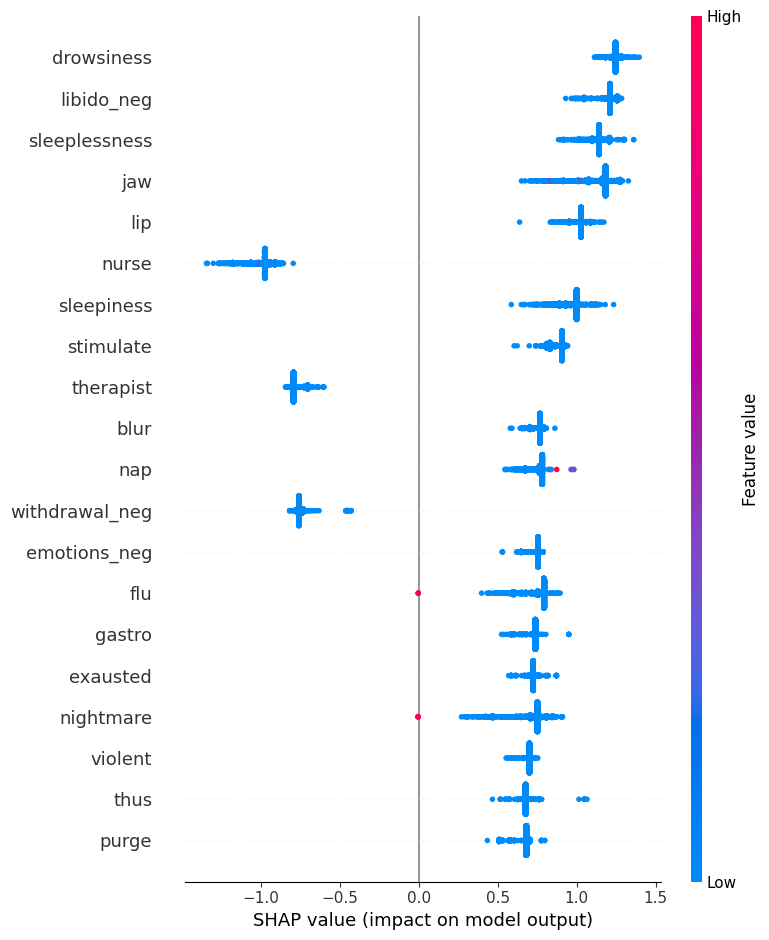

In [ ]:
# ───────────────────────────────────────────────────────────────
# ADR Model Explainability with SHAP
# ───────────────────────────────────────────────────────────────

# Load Packages
import joblib
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# Load saved best model
xgb_pipe = joblib.load('/content/drive/My Drive/best_models/XGBoost_best_model.pkl')

#  Extract TF-IDF, selector and the XGB model
tfidf     = xgb_pipe.named_steps['tfidf']
selector  = xgb_pipe.named_steps['select']
xgb_model = xgb_pipe.named_steps['clf']

# Transform test into numeric matrix
X_test_sel = selector.transform(tfidf.transform(X_test))

# Convert the matrix into a dense array
X_test_arr = X_test_sel.toarray()


explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_arr)

# Global summary plot
feature_names = np.array(tfidf.get_feature_names_out())[selector.get_support()]
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test_arr, feature_names=feature_names)


In [ ]:
# Compute the mean SHAP value per feature across all test instances
mean_shap = np.mean(shap_vals, axis=0)

# Create a DataFrame
df_shap = pd.DataFrame({
    'token': feature_names,
    'mean_shap': mean_shap
})

# Top 15 tokens pushing towards ADR (highest positive mean SHAP)
top15_adr = df_shap.nlargest(15, 'mean_shap')

# Top 15 tokens pushing towards non-ADR (most negative mean SHAP)
top15_nonadr = df_shap.nsmallest(15, 'mean_shap')

print("Top 15 tokens pushing towards ADR:")
display(top15_adr.reset_index(drop=True))

print("\nTop 15 tokens pushing towards non-ADR:")
display(top15_nonadr.reset_index(drop=True))


Top 15 tokens pushing towards ADR:


,token,mean_shap
0,drowsiness,1.243307
1,libido_neg,1.203632
2,sleeplessness,1.138245
3,jaw,1.137141
4,lip,1.022997
5,sleepiness,0.966435
6,stimulate,0.877071
7,blur,0.761100
8,nap,0.760729
9,emotions_neg,0.747848



Top 15 tokens pushing towards non-ADR:


,token,mean_shap
0,nurse,-0.997270
1,therapist,-0.777802
2,withdrawal_neg,-0.754324
3,know,-0.641580
4,offer,-0.631982
5,feel,-0.530417
6,take,-0.369811
7,give_neg,-0.349550
8,spiral,-0.348162
9,make,-0.338810


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3568500565.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metrics_df = metrics_df.applymap(


          Model  Balanced Accuracy  Precision  Recall    F1  Specificty   AUC
0   LogisticReg               0.82       0.82    0.87  0.84        0.77  0.91
1       XGBoost               0.83       0.83    0.86  0.84        0.80  0.91
2  RandomForest               0.83       0.85    0.83  0.84        0.83  0.91
3    NaiveBayes               0.67       0.64    0.97  0.77        0.36  0.90


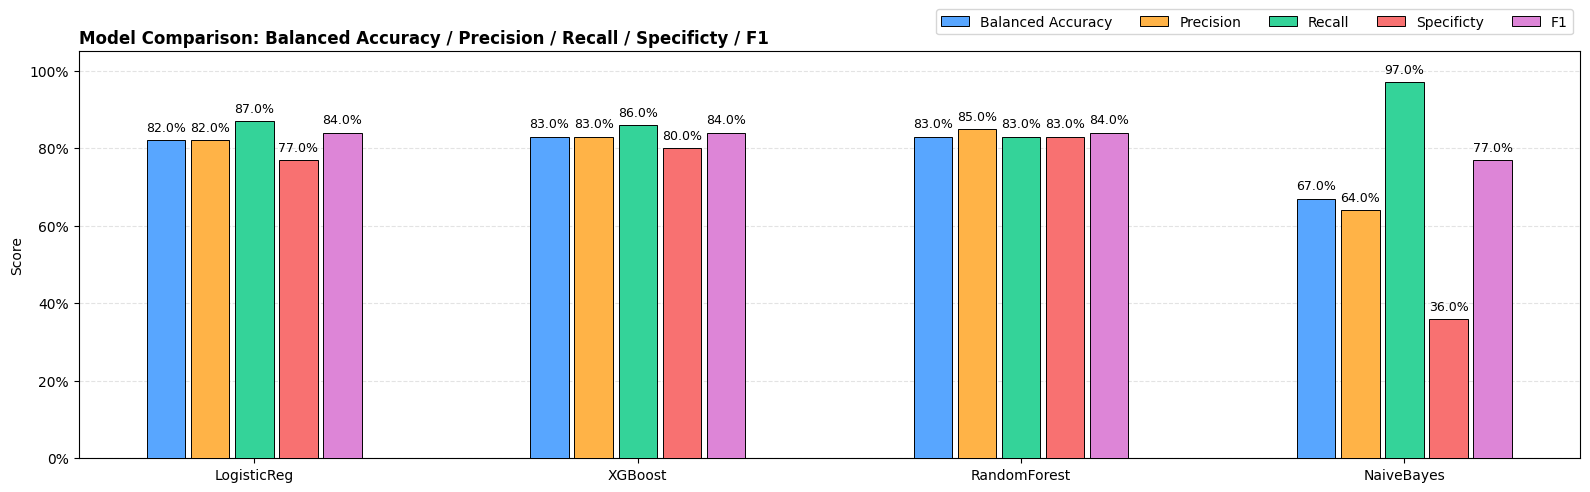

Saved figure to /content/drive/My Drive/best_models/model_comparison.png


<Figure size 640x480 with 0 Axes>

In [15]:
# ───────────────────────────────────────────────────────────────
# ADR Model Evaluation Metrics Bar Plot
# ───────────────────────────────────────────────────────────────

# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# Build data frame from best_models
rows = []
for name, model in best_models.items():
    # get predictions & scores on hold out
    y_pred  = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]

    # compute metrics
    acc   = balanced_accuracy_score(y_test, y_pred)
    prec  = precision_score(y_test, y_pred, zero_division=0)
    rec   = recall_score(y_test, y_pred, zero_division=0)
    f1    = f1_score(y_test, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity  = tn / (tn + fp)
    try:
        auc = roc_auc_score(y_test, y_score)
    except ValueError:
        auc = np.nan

    rows.append({
        "Model":     name,
        "Balanced Accuracy":  acc,
        "Precision": prec,
        "Recall":    rec,
        "F1":        f1,
        "Specificty": specificity,
        "AUC":       auc

    })

metrics_df = pd.DataFrame(rows)
metrics_df = metrics_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)

# ROUND TO 2 SIGNIFICANT FIGURES
metrics_df = metrics_df.applymap(
    lambda x: float(f"{x:.2g}") if isinstance(x, float) else x
)

metrics_df = metrics_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)
print(metrics_df)


# Plot
metric_names = ["Balanced Accuracy", "Precision", "Recall", "Specificty", "F1"]
n_models  = len(metrics_df)
n_metrics = len(metric_names)
x = np.arange(n_models)

palette = ["#58A6FF", "#FFB347", "#34D399", "#F87171","#dd85d7"]
palette = (palette * ((n_metrics // len(palette)) + 1))[:n_metrics]

plt.figure(figsize=(max(9, 4 * n_models), 5))
ax = plt.gca()
ax.set_axisbelow(True)
plt.grid(axis="y", linestyle="--", alpha=0.35, zorder=1)

bar_width = min(0.5 / n_metrics, 0.16)
spacing   = 1.15

for j, metric in enumerate(metric_names):
    offsets  = x + (j - (n_metrics - 1)/2) * bar_width * spacing
    bar_vals = metrics_df[metric].values
    bars     = ax.bar(
        offsets, bar_vals,
        width=bar_width,
        label=metric,
        color=palette[j],
        edgecolor="black",
        linewidth=0.7,
        zorder=3
    )
    for b, v in zip(bars, bar_vals):
        ax.text(
            b.get_x() + b.get_width()/2,
            min(v + 0.015, 1.08),
            f"{v*100:.1f}%",
            ha="center", va="bottom",
            fontsize=9
        )

ax.set_xticks(x)
ax.set_xticklabels(metrics_df["Model"], rotation=0)
ax.set_ylim(0, 1.05)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels([f"{int(t*100)}%" for t in np.linspace(0,1,6)])
ax.set_ylabel("Score")
ax.set_title("Model Comparison: " + " / ".join(metric_names), loc="left", fontweight="bold")
ax.legend(loc="upper right", bbox_to_anchor=(1.0, 1.12), ncol=n_metrics)
plt.tight_layout()
plt.show()

# Save plot
save_path = '/content/drive/My Drive/best_models/model_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to {save_path}")

plt.show()


In [17]:
# Add DeBERTa & RoBERTa rows from CSVs
deberta_df = pd.read_csv('/content/drive/My Drive/best_models/derbeta_model_comparison_metrics.csv')
roberta_df = pd.read_csv('/content/drive/My Drive/best_models/roberta_model_comparison_metrics.csv')

def row_from_csv(df, model_name):
    r = df.iloc[0]

    def get(*cols):
        for c in cols:
            if c in r and pd.notna(r[c]):
                return float(r[c])
        return np.nan

    return {
        "Model":      model_name,
        "Precision":  get("Precision"),
        "Recall":     get("Recall"),
        "Specificty": get("Specificty", "Specificity"),
        "F1":         get("F1", "F1 Score"),
        "Balanced Accuracy": get("Balanced Accuracy"),
        "AUC":        get("AUC", "ROC AUC"),
    }

add_df = pd.DataFrame([
    row_from_csv(deberta_df, "DeBERTa"),
    row_from_csv(roberta_df, "RoBERTa"),
])

# Keep only the columns current metrics_df uses
add_df = add_df[[c for c in ["Model","Precision","Recall","Specificty","F1",
                             "Balanced Accuracy","AUC"] if c in metrics_df.columns]]

# Replace existing rows for these models (if any), then append
metrics_df = metrics_df[~metrics_df["Model"].isin(add_df["Model"])]
metrics_df = pd.concat([metrics_df, add_df], ignore_index=True)


Saved figure to /content/drive/My Drive/best_models/model_comparison.pdf


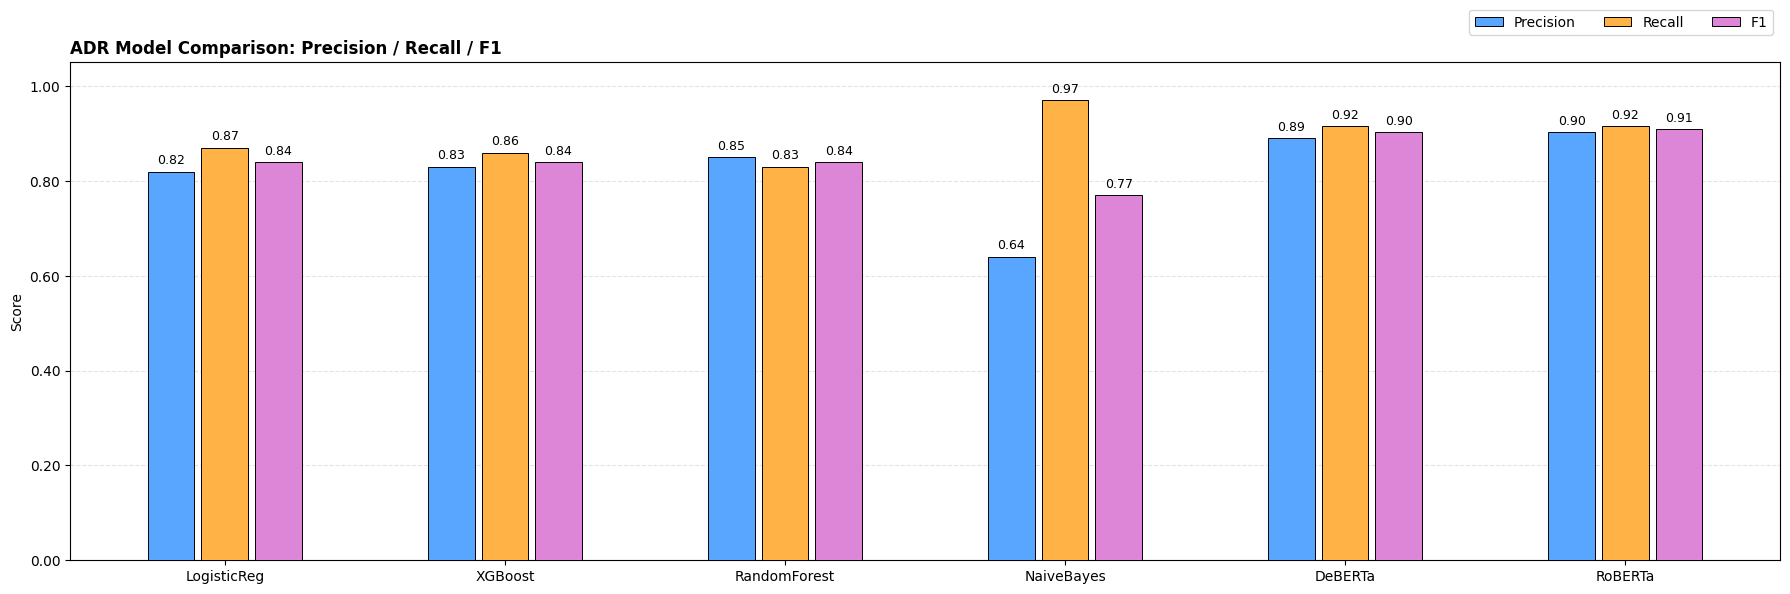

In [38]:

# Plot
metric_names = ["Precision", "Recall", "F1"]
n_models  = len(metrics_df)
n_metrics = len(metric_names)

# shrink inter-model gap by scaling x
group_spacing = 0.9
x = np.arange(n_models) * group_spacing

palette = ["#58A6FF", "#FFB347", "#dd85d7", "#dd85d7"]
palette = (palette * ((n_metrics // len(palette)) + 1))[:n_metrics]

# make the figure a bit narrower in width and taller in height
plt.figure(figsize=(max(3, 3 * n_models), 6))
ax = plt.gca()
ax.set_axisbelow(True)
plt.grid(axis="y", linestyle="--", alpha=0.35, zorder=1)

# slightly larger bar width
bar_width = min(0.45 / n_metrics, 0.2)
spacing   = 1.15

for j, metric in enumerate(metric_names):
    offsets  = x + (j - (n_metrics - 1)/2) * bar_width * spacing
    bar_vals = metrics_df[metric].values
    bars     = ax.bar(
        offsets, bar_vals,
        width=bar_width,
        label=metric,
        color=palette[j],
        edgecolor="black",
        linewidth=0.7,
        zorder=3
    )
    for b, v in zip(bars, bar_vals):
        ax.text(
            b.get_x() + b.get_width()/2,
            v + 0.01,
            f"{v:.2f}",
            ha="center", va="bottom",
            fontsize=9
        )

ax.set_xticks(x)
ax.set_xticklabels(metrics_df["Model"], rotation=0)
ax.set_ylim(0, 1.05)
ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels([f"{t:.2f}" for t in np.linspace(0,1,6)])
ax.set_ylabel("Score")
ax.set_title("ADR Model Comparison: " + " / ".join(metric_names), loc="left", fontweight="bold")
ax.legend(loc="upper right", bbox_to_anchor=(1.0, 1.12), ncol=n_metrics)

plt.tight_layout()

# Save plot
save_path = '/content/drive/My Drive/best_models/model_comparison.pdf'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to {save_path}")

# Display on-screen
plt.show()


Saved figure to:
  /content/drive/My Drive/best_models/balanced_accuracy_curve_zoomed_max1.pdf
  /content/drive/My Drive/best_models/balanced_accuracy_curve_zoomed_max1.png


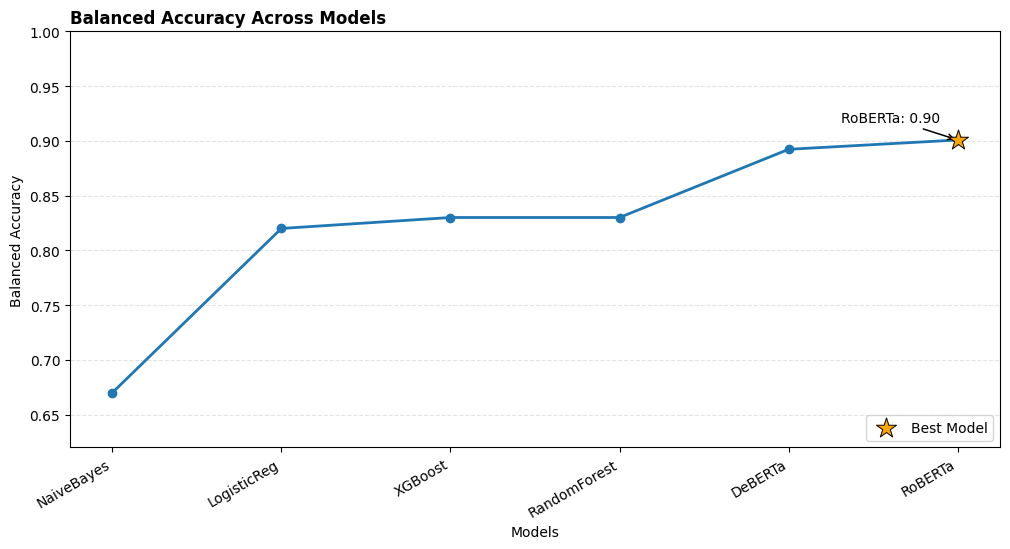

In [28]:
# Balanced Accuracy Plot

# Build a dataframe with Balanced Accuracy
ba_df = metrics_df[["Model", "Balanced Accuracy"]].dropna().copy()
ba_df = ba_df.sort_values("Balanced Accuracy", ascending=True).reset_index(drop=True)

models = ba_df["Model"].tolist()
y = ba_df["Balanced Accuracy"].astype(float).values
x = np.arange(len(models))

# Highlight RoBERTa if present, else the max
def is_roberta(name: str) -> bool:
    n = str(name).strip().lower()
    return n == "roberta" or n.startswith("roberta")

hi_idx = next((i for i, m in enumerate(models) if is_roberta(m)), None)
if hi_idx is None:
    hi_idx = int(np.argmax(y))

hi_name = models[hi_idx]
hi_y    = y[hi_idx]

hi = 1.0
lo = max(0.0, y.min() - 0.05)
if lo == 0.0:
    lo = max(0.01, y.min() - 0.02)
# ensure lo < hi
lo = min(lo, 0.98)

span = hi - lo
step = 0.02 if span <= 0.20 else 0.05
start = np.floor(lo/step)*step
ticks = np.round(np.arange(start, hi + 1e-9, step), 2)

# Annotation offset scales with span
dy = 0.03 * span + 0.002

# Plot
plt.figure(figsize=(max(9, 0.7 * len(models) + 6), 5.6))
plt.plot(x, y, marker="o", linewidth=2, zorder=3)

# Orange star on highlight
plt.scatter([hi_idx], [hi_y], marker="*", s=230, zorder=4,
            color="orange", edgecolor="k", linewidth=0.7, label="Best Model")

# Annotation
plt.annotate(f"{hi_name}: {hi_y:.2f}",
             xy=(hi_idx, hi_y),
             xytext=(hi_idx - 0.4, hi_y + dy),
             ha="center", va="bottom",
             arrowprops=dict(arrowstyle="->", lw=1.1))

# Axes & styling
plt.xticks(x, models, rotation=30, ha="right")
plt.yticks(ticks, [f"{t:.2f}" for t in ticks])
plt.ylim(lo, hi)
plt.grid(axis="y", linestyle="--", alpha=0.35)

plt.title("Balanced Accuracy Across Models", loc="left", fontweight="bold")
plt.xlabel("Models")
plt.ylabel("Balanced Accuracy")
plt.legend(loc="lower right")
plt.tight_layout()

# Save & show
save_dir = '/content/drive/My Drive/best_models'
os.makedirs(save_dir, exist_ok=True)
pdf_path = os.path.join(save_dir, 'balanced_accuracy_curve_zoomed_max1.pdf')
png_path = os.path.join(save_dir, 'balanced_accuracy_curve_zoomed_max1.png')
plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
plt.savefig(png_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to:\n  {pdf_path}\n  {png_path}")
plt.show()

